# Vanilla modelling



---


# TODO:

- Convert to AE and then just visualize latent space for analysis?

- maybe do some variable transformation? e.g. power, show only start and stop? and quantiles

- Can you set outlier thresholds clf based on train/test set error?


---


In [ ]:
import os
import time
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import nexusformat.nexus as nx
import pickle
import json
from tqdm import tqdm
import datetime
import matplotlib.dates as mdates
from datetime import timedelta

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from fault_management_uds.data.hdf_functions import print_tree, load_dataframe_from_HDF5
from fault_management_uds.data.process import remove_nans_from_start_end

from fault_management_uds.plots import set_meaningful_xticks

from fault_management_uds.config import indicator_2_meta, bools_2_meta, error_indicators, natural_sensor_order


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR


from fault_management_uds.data.load_data import import_external_metadata, import_metadata
from fault_management_uds.data.load_data import load_data_period, filenames_based_on_period, provided_2_full_range
from fault_management_uds.data.load_data import get_event, create_individual_indicators, create_indicator


# Anomaly generation
from fault_management_uds.multi_data_validation.multi_data_validation import anomaly_generators as ag


from fault_management_uds.dataset import TimeSeriesDataset

# set random seed
np.random.seed(11)


TODO:
- make the dataset
    - data loader
    - valid windows? hmmm
    - load based on time index of valid
    - train test
- create the models

- train
    - plot loss
    - plot metrics

- baseline

## Load data

In [2]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'

In [ ]:
sensor_name = 'G71F04R_Level2'

# load sensor data
sensor_data, _, _, _ = load_dataframe_from_HDF5(data_file_path, f"single_series/sewer_data/{sensor_name}/{sensor_name}_clean", complete_range=True, verbose=False)
sensor_data.columns = [sensor_name]
print(f"Sensor data shape: {sensor_data.shape}")
# load rain data
rain_data, _, _, _ = load_dataframe_from_HDF5(data_file_path, f"single_series/rain_gauge_data/5425", complete_range=True, verbose=False)
print(f"Rain data shape: {rain_data.shape}")
rain_data.columns = ['rain']

Sensor data shape: (5810602, 1)
Rain data shape: (6419907, 1)


In [4]:
# combine sensor and rain data in a single df where time index is the same/overlaps
sensor_data = sensor_data.loc[sensor_data.index.intersection(rain_data.index)]
rain_data = rain_data.loc[rain_data.index.intersection(sensor_data.index)]

combined_data = pd.concat([rain_data, sensor_data], axis=1)
print(f"Combined data shape: {combined_data.shape}")

del sensor_data, rain_data

Combined data shape: (5810602, 2)


#### Set parameters related to the data in training

In [5]:
sequence_length = 120 
step_size = 5

In [6]:
print(combined_data[sensor_name].isna().sum())

465543


#### Ensure modelling is only performed on valid data

In [7]:
def extract_valid_windows(df, sequence_length, step_size=1):
    """
    Extracts valid sequences of the specified length from a time series DataFrame,
    excluding windows with NaN values.

    Args:
        df: Time series DataFrame with a datetime index.
        sequence_length: Desired length of the sequences (in time units).
        step_size: Step size for iterating through the DataFrame (in time units).

    Returns:
        valid_indices: List of starting indices of valid sequences.
        valid_timestamps: List of corresponding timestamps for the valid sequences.
    """

    valid_indices = []
    valid_timestamps = []

    for start_idx in tqdm(range(0, len(df) - sequence_length + 1, step_size), total=len(df)//step_size):
        end_idx = start_idx + sequence_length
        window = df.iloc[start_idx:end_idx]

        # Check if there are any NaN values in the window
        if not window.isnull().values.any():
            valid_indices.append(start_idx)
            valid_timestamps.append(df.index[start_idx])

    return valid_indices, valid_timestamps

In [8]:
# get valid window indices
valid_indices, valid_timestamps = extract_valid_windows(combined_data[sensor_name], sequence_length, step_size)

print(f"Number of valid time indices: {len(valid_indices)} out of {len(combined_data)}")


100%|█████████▉| 1162097/1162120 [00:30<00:00, 37713.92it/s]


Number of valid time indices: 1054674 out of 5810602


## Create dataset and dataloader

#### Split the data

In [9]:
# turn valid indices and timestamps into a DataFrame
valid_windows = pd.DataFrame({'start_idx': valid_indices, 'timestamp': valid_timestamps})

In [10]:
# split the data into training, validation and test sets
# stratify on year else random

valid_windows['year'] = valid_windows['timestamp'].dt.year


# Define ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# First split the data into train and temp (which will be split again into val and test)
train_windows, temp_data = train_test_split(valid_windows, test_size=(1 - train_ratio), stratify=valid_windows['year'])

# Split the temp data into val and test
val_windows, test_windows = train_test_split(temp_data, test_size=test_ratio/(test_ratio + val_ratio), stratify=temp_data['year'])

# Check the ratios
print(f"Train ratio: {len(train_windows)/len(valid_windows)}, Train size: {len(train_windows)}")
print(f"Val ratio: {len(val_windows)/len(valid_windows)}, Val size: {len(val_windows)}")
print(f"Test ratio: {len(test_windows)/len(valid_windows)}, Test size: {len(test_windows)}")

# TODO: save the split indices?


Train ratio: 0.6999992414717723, Train size: 738271
Val ratio: 0.14999990518397155, Val size: 158201
Test ratio: 0.15000085334425614, Test size: 158202


In [39]:
def collect_indices(window_data, sequence_length):
    # Generate all indices for the given windows
    all_indices = np.concatenate([np.arange(idx, idx + sequence_length) for idx in window_data['start_idx']])
    
    # Use np.unique to remove duplicates and sort in one step
    unique_sorted_indices = np.unique(all_indices)

    # get the location of all the start indices
    start_indices = window_data['start_idx'].values
    # get the location of the start indices in the unique_sorted_indices
    start_indices_locations = np.where(np.isin(unique_sorted_indices, start_indices))[0]
    
    return unique_sorted_indices, start_indices_locations

# given the split indices, get the corresponding data - note, from start_idx to start_idx + sequence_length
train_indices, train_start_indices = collect_indices(train_windows, sequence_length)
val_indices, val_start_indices = collect_indices(val_windows, sequence_length)
test_indices, test_start_indices = collect_indices(test_windows, sequence_length)

# get the corresponding data
train_data = combined_data.iloc[train_indices]
val_data = combined_data.iloc[val_indices]
test_data = combined_data.iloc[test_indices]


In [40]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1)) # preserve original data range, i.e. relative scaling
# - sensitive to outliers, and not good for negative values
#scaler = StandardScaler() # normalises to mean 0 and std 1, not sensitive to outliers, and can handle negative values
# - but the data is not bounded, so the model can predict values outside the original range
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

#### Create the loaders


In [41]:
# Define batch size for training
batch_size = 64


# Create dataset and dataloader for the training set
train_dataset = TimeSeriesDataset(train_data.values, train_start_indices, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)


# Create dataset and dataloader for the validation set
val_dataset = TimeSeriesDataset(val_data.values, val_start_indices, sequence_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


# Create dataset and dataloader for the test set
test_dataset = TimeSeriesDataset(test_data.values, test_start_indices, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


## Model

In [44]:
class LitAutoEncoderConv1D(pl.LightningModule):
    def __init__(self, scaler, idx_rain, idx_sensor, latent_size, num_filters, kernel_size):
        super(LitAutoEncoderConv1D, self).__init__()
        
        self.scaler = scaler
        self.idx_rain = idx_rain
        self.idx_sensor = idx_sensor
        self.latent_size = latent_size
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        
        self.encoder_rain = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=int(num_filters/2), kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=int(num_filters/2), out_channels=int(latent_size/2), kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU()
        )

        self.encoder_sensor = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=int(num_filters/2), kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=int(num_filters/2), out_channels=int(latent_size/2), kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=latent_size, out_channels=int(num_filters/2), kernel_size=kernel_size, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=int(num_filters/2), out_channels=1, kernel_size=kernel_size, stride=1, padding=1),
            # For 0, 1 output, use sigmoid activation
            nn.Sigmoid()
            # For -1 to 1 output, use tanh activation
            # nn.Tanh()
            # For any other output, use ReLU activation
            # nn.ReLU()

        )

    
    def forward(self, x):
        # use the idx_rain and idx_sensor to separate the data
        rain_data = x[:, :, self.idx_rain].unsqueeze(1)  # (batch_size, 1, seq_len)
        sensor_data = x[:, :, self.idx_sensor].unsqueeze(1)  # (batch_size, 1, seq_len)
        
        # Pass through separate encoders
        latent_rain = self.encoder_rain(rain_data)
        latent_sensor = self.encoder_sensor(sensor_data)
        
        # Concatenate latent representations
        latent = torch.cat((latent_rain, latent_sensor), dim=1)  # (batch_size, latent_size, seq_len)
        
        # Pass through decoder (only 1 output channel for sensor data)
        reconstructed_sensor = self.decoder(latent)
        return reconstructed_sensor.squeeze(1)  # Remove the channel dimension



    def training_step(self, batch, batch_idx):
        x = batch
        reconstructed_sensor = self.forward(x)
        sensor_data = x[:, :, self.idx_sensor].squeeze(1)
        loss = nn.functional.mse_loss(reconstructed_sensor, sensor_data)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch
        reconstructed_sensor = self.forward(x)
        sensor_data = x[:, :, self.idx_sensor].squeeze(1)
        loss = nn.functional.mse_loss(reconstructed_sensor, sensor_data)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


In [34]:
# # Define the PyTorch Lightning Module for Autoencoder
# class LitAutoEncoder(pl.LightningModule):
#     def __init__(self, input_size, latent_size):
#         super(LitAutoEncoder, self).__init__()
        
#         # Encoder: Reduces input to a lower dimension (latent space)
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, latent_size)
#         )
        
#         # Decoder: Reconstructs the input from the latent space
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_size, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, input_size),
#             nn.Sigmoid()  # Assuming input is normalized to [0, 1]
#         )
        
#         # Store loss history
#         self.train_losses = []
#         self.val_losses = []



#     def forward(self, x):
#         # Encode and then decode the input
#         x = x.to(torch.float32)  # Ensure input is float32 before any operations
#         latent = self.encoder(x)
#         reconstructed = self.decoder(latent)
#         return reconstructed
    
#     def training_step(self, batch, batch_idx):
#         # Unpack batch
#         x = batch
#         # Forward pass: encode and decode
#         reconstructed = self.forward(x)
#         # Loss: mean squared error between input and reconstruction
#         loss = nn.functional.mse_loss(reconstructed, x)
#         # Log the loss for progress tracking
#         self.log('train_loss', loss)
#         self.train_losses.append(loss.item())  # Store training loss
#         return loss
    
#     def validation_step(self, batch, batch_idx):
#         # Validation step similar to training
#         x = batch
#         reconstructed = self.forward(x)
#         loss = nn.functional.mse_loss(reconstructed, x)
#         self.log('val_loss', loss)
#         self.val_losses.append(loss.item())  # Store validation loss
#         return loss
    
#     def configure_optimizers(self):
#         # Adam optimizer
#         return optim.Adam(self.parameters(), lr=1e-3)

## Train

In [75]:
latent_size = 16
# Initialize the autoencoder
# TODO: should it reconstruct sensor, or sensor and rain since rain also in input?
# - think sensor only - adjust
#model = LitAutoEncoder(input_size=input_size, latent_size=latent_size)
model = LitAutoEncoderConv1D(scaler=scaler, idx_rain=0, idx_sensor=1, latent_size=latent_size, num_filters=32, kernel_size=3)

In [76]:
# Test the model with a random input
# Get the input size
for batch in train_loader:
    input_shape = batch.size()
    break

# Test the forward pass based on the input shape
x = torch.randn(input_shape)
reconstructed = model(x)
print(reconstructed.size())

2024-10-24 09:22:05.793 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


torch.Size([64, 120])


In [77]:
# # TODO: do it within the verison
models_log_dir = MODELS_DIR / 'autoencoder'
os.makedirs(models_log_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(dirpath=models_log_dir, filename='best-val-loss-{epoch}.ckpt',
                                      save_top_k=1, monitor='val_loss', mode='min')


In [78]:

num_epochs = 2
check_val_every_n_epoch = 1
log_every_n_steps = 50
# Initialize the Trainer (can be customized with various options)
trainer = pl.Trainer(max_epochs=num_epochs, check_val_every_n_epoch=check_val_every_n_epoch, log_every_n_steps=log_every_n_steps,
    accelerator='mps', default_root_dir=models_log_dir,
    callbacks=[checkpoint_callback],
    #fast_dev_run=True,
    )

# Train the model
trainer.fit(model, train_loader, val_loader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder_rain   | Sequential | 456    | train
1 | encoder_sensor | Sequential | 456    | train
2 | decoder        | Sequential | 833    | train
------------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

2024-10-24 09:22:12.115 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


2024-10-24 09:22:13.226 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


Epoch 0: 100%|██████████| 11536/11536 [01:28<00:00, 130.37it/s, v_num=5, train_loss=5.5e-6]  

2024-10-24 09:23:42.665 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


Epoch 1:   0%|          | 0/11536 [00:00<?, ?it/s, v_num=5, train_loss=5.5e-6, val_loss=0.000169]             

2024-10-24 09:23:55.677 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


Epoch 1: 100%|██████████| 11536/11536 [01:32<00:00, 124.57it/s, v_num=5, train_loss=0.000224, val_loss=0.000169]

2024-10-24 09:25:28.334 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


Epoch 1: 100%|██████████| 11536/11536 [01:45<00:00, 109.50it/s, v_num=5, train_loss=0.000224, val_loss=0.000167]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 11536/11536 [01:45<00:00, 109.43it/s, v_num=5, train_loss=0.000224, val_loss=0.000167]


#### Load the model

In [ ]:
# TODO: version
# load the best model
best_model_path = models_log_dir / 'best-val-loss.ckpt'

## Evaluate

In [59]:
version = 3
metrics_df = pd.read_csv(models_log_dir / 'lightning_logs' / f'version_{version}' / 'metrics.csv')
metrics_df.head()

,epoch,step,train_loss,val_loss
0,0,49,0.077615,NaN
1,0,99,0.012908,NaN
2,0,149,0.001447,NaN
3,0,199,0.003742,NaN
4,0,249,0.000783,NaN


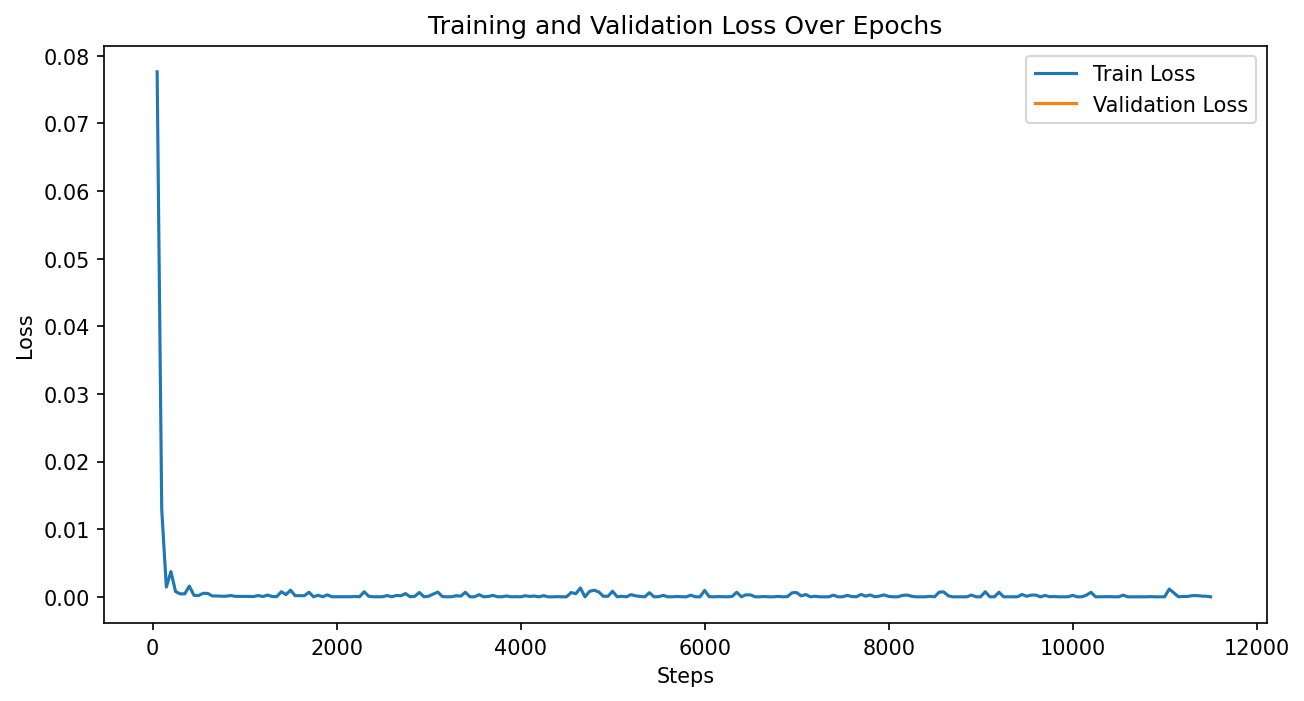

In [66]:
# Plot training and validation loss
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(metrics_df['step'], metrics_df['train_loss'], label='Train Loss')
plt.plot(metrics_df['step'], metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

#### Evaluate the model on the test set

In [68]:
trainer

#### Baseline comparison

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
mean_sensor_train = np.mean(x_train[:, :, idx_sensor], axis=0)

# Use mean for prediction
y_pred_mean = np.tile(mean_sensor_train, (x_test.shape[0], 1, 1))

# Evaluate
mse_mean = mean_squared_error(y_test[:, :, idx_sensor], y_pred_mean)
print(f'Mean Predictor MSE: {mse_mean}')

In [65]:

# Prepare data (assuming x_train, y_train, x_test, y_test are prepared and scaled)
model_lr = LinearRegression()
model_lr.fit(x_train[:, :, idx_sensor], y_train[:, :, idx_sensor])

# Predictions
y_pred_lr = model_lr.predict(x_test[:, :, idx_sensor])

# Evaluate
mse_lr = mean_squared_error(y_test[:, :, idx_sensor], y_pred_lr)
print(f'Linear Regression MSE: {mse_lr}')

NameError: name 'x_train' is not defined

In [ ]:
# Test the model on the test set
trainer.test(test_dataloaders=test_loader)




TODO:
- check with a baseline
- visualize reconstruction
- visualize the latent space
    - additional, color with synthetic?

improve
- lstm

# TODO:

- what about the low value data?
- something about transforming the rain variable?